In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 
from collections import deque, namedtuple 

# Plotting configuration
sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"Gymnasium Version: {gym.__version__}")

# For reproducibility and device selection
torch.manual_seed(42)
np.random.seed(42)
random.seed(42) # For Python's random module
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 2.3.0+cu118
Gymnasium Version: 1.1.1
Using device: cuda


In [2]:
# Environment setup (CartPole)
env_name = 'CartPole-v1'
try:
    env = gym.make(env_name)
except gym.error.DeprecatedEnv:
    env = gym.make('CartPole-v0')

In [3]:
env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

In [4]:
state_dim_rl = env.observation_space.shape[0]
action_dim_rl = env.action_space.n
print(state_dim_rl, action_dim_rl)
env.close()

4 2


### Deep Q-Networks (DQN)

In [5]:
# MLP for cartpole
class QNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_q_values = nn.Linear(hidden_dim, action_dim)

    def forward(self, state_tensor):
        x = F.relu(self.fc1(state_tensor))
        x = F.relu(self.fc2(x))
        q_values = self.fc3_q_values(x)
        return q_values    

In [19]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

In [20]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        """Sample a batch of transitions"""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [21]:
# epsilon greedy action selection
def select_action_epsilon_greedy(state_tensor, policy_net, epsilon, n_actions):
    if random.random() > epsilon:
        with torch.no_grad():
            if state_tensor.ndim == 1:
                state_tensor = state_tensor.unsqueeze(0)
            action = policy_net(state_tensor).max(1)[1].view(1, 1)
            return action
    else:       # choose a random action
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

In [22]:
# DQN Algorithm Implementation
buffer_size = 10000
batch_size = 128
gamma = 0.99
eps_start = 0.9
eps_end = 0.05
eps_decay = 1000
tau = 0.005
target_update_freq = 10
lr = 1e-3
num_episodes = 600
max_steps = 500

In [23]:
# Initialize Q-network (policy_net) and Target Q-Network (target_net)
policy_q_net = QNetwork(state_dim_rl, action_dim_rl).to(device)
target_q_net = QNetwork(state_dim_rl, action_dim_rl).to(device)
target_q_net.load_state_dict(policy_q_net.state_dict())
target_q_net.eval()

QNetwork(
  (fc1): Linear(in_features=4, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3_q_values): Linear(in_features=128, out_features=2, bias=True)
)

In [24]:
optimizer = optim.AdamW(policy_q_net.parameters(), lr=lr, amsgrad=True)
replay_memory = ReplayBuffer(buffer_size)

In [25]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

In [26]:
replay_memory

In [27]:
steps_done = 0
episode_rewards = []
for episode_i in range(num_episodes):
    dqn_env = gym.make(env_name)
    state_np_dqn, info_dqn = dqn_env.reset(seed=42 + episode_i)
    state_dqn = torch.from_numpy(state_np_dqn).float().unsqueeze(0).to(device)

    current_episode_reward = 0

    for t_dqn in range(max_steps):
        epsilon = eps_end + (eps_start - eps_end) * np.exp(-1. * steps_done / eps_decay)
        steps_done += 1

        action_dqn = select_action_epsilon_greedy(state_dqn, policy_q_net, epsilon, action_dim_rl)

        next_state_np_dqn, reward_dqn, terminated_dqn, truncated_dqn, _ = dqn_env.step(action_dqn.item())
        done_dqn = terminated_dqn or truncated_dqn
        current_episode_reward += reward_dqn

        reward_tensor_dqn = torch.tensor([reward_dqn], device=device, dtype=torch.float32)
        done_tensor_dqn = torch.tensor([done_dqn], device=device, dtype=torch.bool)

        if terminated_dqn:
            next_state_dqn = None
        else:
            next_state_dqn = torch.from_numpy(next_state_np_dqn).float().unsqueeze(0).to(device)

        # store the transition in replay memory
        replay_memory.push(state_dqn, action_dqn, next_state_dqn, reward_tensor_dqn, done_tensor_dqn)

        # move to the next state
        state_dqn = next_state_dqn

        # perform one step of optimization on the policy network
        if len(replay_memory) >= batch_size:
            transitions = replay_memory.sample(batch_size)
            batch = Transition(*zip(*transitions))

            # compute a mask of non-final states and concatenate the batch elements
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),
                                          device=device, dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)      # [batch_size, 1]
            reward_batch = torch.cat(batch.reward)      # [batch_size]
            done_batch = torch.cat(batch.done)          # [batch_size]

            state_action_values = policy_q_net(state_batch).gather(1, action_batch)     # Q(s,a)

            # Compute V(s_{t+1}) for all next states.
            next_state_values = torch.zeros(batch_size, device=device)
            if non_final_next_states.nelement() > 0:
                with torch.no_grad():
                    next_state_values[non_final_mask] = target_q_net(non_final_next_states).max(1)[0]

            # compute expected Q Values (Bellman target)
            expected_state_action_values = (next_state_values * gamma) + reward_batch
            # for terminal states, future reward component (next_state_values * gamma) is zero because next_state_values for done states will be zero

            # compute Huber loss or MSE loss
            criterion = nn.SmoothL1Loss() 
            # criterion = nn.MSELoss()
            loss_dqn = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

            # optimize the model
            optimizer.zero_grad()
            loss_dqn.backward()
            torch.nn.utils.clip_grad_value_(policy_q_net.parameters(), 100)
            optimizer.step()

        if done_dqn:
            break

    dqn_env.close()
    episode_rewards.append(current_episode_reward)

    # update the target network
    if episode_i % target_update_freq == 0:
        target_q_net.load_state_dict(policy_q_net.state_dict())

    if (episode_i) % 50 == 0:
        avg_reward = np.mean(episode_rewards[-50:])
        print(f"DQN Episode {episode_i+1}/{num_episodes}, Avg Reward (last 50): {avg_reward:.2f}, Epsilon: {epsilon:.3f}")
        if avg_reward >= 475.0 and num_episodes > 100:
            print(f"CartPole solved by DQN at episode {episode_i+1}!")

DQN Episode 1/600, Avg Reward (last 50): 9.00, Epsilon: 0.893
DQN Episode 51/600, Avg Reward (last 50): 61.58, Epsilon: 0.089
DQN Episode 101/600, Avg Reward (last 50): 168.92, Epsilon: 0.050
DQN Episode 151/600, Avg Reward (last 50): 163.00, Epsilon: 0.050
DQN Episode 201/600, Avg Reward (last 50): 93.72, Epsilon: 0.050
DQN Episode 251/600, Avg Reward (last 50): 115.88, Epsilon: 0.050
DQN Episode 301/600, Avg Reward (last 50): 119.94, Epsilon: 0.050
DQN Episode 351/600, Avg Reward (last 50): 125.34, Epsilon: 0.050
DQN Episode 401/600, Avg Reward (last 50): 151.92, Epsilon: 0.050
DQN Episode 451/600, Avg Reward (last 50): 174.32, Epsilon: 0.050
DQN Episode 501/600, Avg Reward (last 50): 118.84, Epsilon: 0.050
DQN Episode 551/600, Avg Reward (last 50): 152.68, Epsilon: 0.050


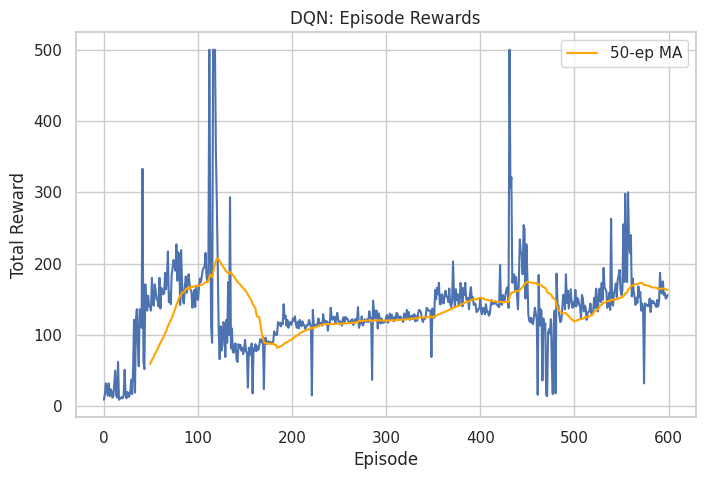

In [29]:
plt.figure(figsize=(8,5))
plt.plot(episode_rewards)
plt.title("DQN: Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
if len(episode_rewards) >= 50:
    rewards_ma_dqn = np.convolve(episode_rewards, np.ones(50)/50, mode='valid')
    plt.plot(np.arange(49, len(episode_rewards)), rewards_ma_dqn, label='50-ep MA', color='orange')
plt.legend()
plt.show()